<a href="https://colab.research.google.com/github/kiakass/recommendation/blob/main/lightFM_jameshope_movies_210924_realdata_weight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference site : https://greeksharifa.github.io/machine_learning/2020/06/01/LightFM/ <br>
thesis : https://github.com/kiakass/share/blob/master/Metadata%20Embeddings%20for%20User%20and%20Item%20Cold-start%20.pdf <br>
LightFM’s documentation! : https://making.lyst.com/lightfm/docs/home.html <br>
WARP : https://making.lyst.com/lightfm/docs/examples/warp_loss.html#preliminaries<br>
precision@k : https://github.com/lyst/lightfm/blob/master/examples/movielens/readme.md <br>


In [1]:
!pip install feather-format

In [2]:
!pip install typing

     |████████████████████████████████| 78 kB 3.3 MB/s 
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26324 sha256=2b922ca22bd4d6328693f76760a63f2e3e85c568bca54d51b3f2b4ad3384342b
  Stored in directory: /root/.cache/pip/wheels/35/f3/15/01aa6571f0a72ee6ae7b827c1491c37a1f72d686fd22b43b0e
Successfully built typing


In [3]:
!pip install lightfm

     |████████████████████████████████| 310 kB 5.2 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705368 sha256=ae63b62b2f81b9df4ff77b994dfe00e65ec85c879edc5849769aa6ae148da903
  Stored in directory: /root/.cache/pip/wheels/f8/56/28/5772a3bd3413d65f03aa452190b00898b680b10028a1021914
Successfully built lightfm


In [4]:
from lightfm import LightFM
from scipy.sparse import coo_matrix as sp
import time
import matplotlib.pyplot as plt
import os
import zipfile
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score
from lightfm.cross_validation import random_train_test_split 

import numpy as np
import pandas as pd
import warnings # warings 제거
warnings.filterwarnings(action='ignore')

import zlib

pd.set_option('display.max_row', 500) #출력행수

In [5]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [6]:
!ls /gdrive/My\ Drive/10.data/논문마트

customer.csv
iptv_seg_use.csv
item_features.csv
L1AGGR_SEG_IPTV_USE_CLUSTERING_0.csv
L1AGGR_SEG_IPTV_USE_CLUSTERING_1.csv
L1AGGR_SEG_IPTV_USE_CLUSTERING_2.csv
L1AGGR_SEG_IPTV_USE_CLUSTERING_3.csv
L1AGGR_SEG_IPTV_USE_CLUSTERING_4.csv
L1AGGR_SEG_IPTV_USE_CLUSTERING_5.csv
L1AGGR_SEG_IPTV_USE_CLUSTERING_6.csv
L1AGGR_SEG_IPTV_USE_CLUSTERING_7.csv
L1AGGR_SEG_IPTV_USE_CLUSTERING_8.csv
L1AGGR_SEG_IPTV_USE_CLUSTERING_9.csv
L1AGGR_SEG_IPTV_USE_CLUSTERING.csv
L1AGGR_SEG_IPTV_USE_CLUSTERING_H.210918.csv
L1AGGR_SEG_IPTV_USE_CLUSTERING_H.csv
user_features_r20.csv
user_feaures.csv
user_item_interaction_adj.csv
user_item_interaction.csv
user_item_interaction_r20.csv
USER_ITEM_INTERACTIONS_R20.csv


### $ {\color{Blue} {Data \, loading }}$
- user\_features, item\_features

#### 1. Load data

In [7]:
dir='/gdrive/My Drive/10.data/논문마트/'
user_item_interactions = pd.read_csv(dir+'USER_ITEM_INTERACTIONS_R20.csv', delimiter=',',dtype={'wtch_dt': str,'buy_dt': str })
user_item_interactions.rename(columns={'userid':'userId'}, inplace = True)
user_item_interactions.rename(columns={'movieid':'movieId'}, inplace = True)

In [8]:
'''
df_interactions = pd.read_csv(dir+'USER_ITEM_INTERACTIONS_R20.csv', delimiter=',',dtype={'wtch_dt': str,'buy_dt': str })
df_interactions.rename(columns={'userid':'userId'}, inplace = True)
df_interactions.rename(columns={'movieid':'movieId'}, inplace = True)
'''

"\ndf_interactions = pd.read_csv(dir+'USER_ITEM_INTERACTIONS_R20.csv', delimiter=',',dtype={'wtch_dt': str,'buy_dt': str })\ndf_interactions.rename(columns={'userid':'userId'}, inplace = True)\ndf_interactions.rename(columns={'movieid':'movieId'}, inplace = True)\n"

In [9]:
df_user_features = pd.read_csv(dir+'user_features_r20.csv', delimiter=',')
df_user_features.rename(columns={'userid':'userId'}, inplace = True)

In [10]:
df_item_features = pd.read_csv(dir+'item_features.csv', delimiter=',')
df_item_features.rename(columns={'movieid':'movieId'}, inplace = True)

#### 2.Make Weighting/Rating

In [11]:
# 가중치 만들기, Weight()
#wtch_yn,buy_yn,wtch_pg_cnt,buy_pg_cnt,sch_cnt,wish_yn,story_yn,review_yn,preview_yn,rating_yn
a=pd.DataFrame([67046,10062,132844,16016,16984,1295,422,447,82,326,140000],columns=['weight'])
hw=pd.DataFrame([1.2,1.5,1,1,1,1,1,1,1,1,1],columns=['weight'])
f=lambda x: 1/(1+np.exp(-(1-x/4800000)))  # 
#f=lambda x: np.log10(4800000/x)*np.log10(x)
b=f(a)

#normalize : 영향도 경감
def normalize_df(x):
  return (x-x.min())/(x.max()-x.min())

w=normalize_df(b).mul(hw);print(pd.merge(b,w,on=b.index))

    key_0  weight_x  weight_y
0       0  0.728303  0.627678
1       1  0.730646  1.393671
2       2  0.725583  0.051466
3       3  0.730402  0.886791
4       4  0.730362  0.879908
5       5  0.731006  0.991388
6       6  0.731041  0.997586
7       7  0.731040  0.997409
8       8  0.731055  1.000000
9       9  0.731045  0.998268
10     10  0.725286  0.000000


In [12]:
nor_interactions=user_item_interactions.iloc[:,:]
columns=user_item_interactions.iloc[:,3:].columns;print(columns)
df_b=pd.DataFrame(normalize_df(user_item_interactions.iloc[:,3:].fillna(0)),columns=columns)
nor_interactions[columns]=df_b

Index(['wtch_pg_cnt', 'buy_pg_cnt', 'wtch_yn', 'wtch_tm', 'wtch_cp', 'buy_dt',
       'buy_yn', 'buy_amt', 'sch_cnt', 'wish_yn', 'story_yn', 'review_yn',
       'preview_yn', 'rating_yn'],
      dtype='object')


In [13]:
# rating 계산 : dot product
nor_interactions['rating']=normalize_df(np.dot(nor_interactions.iloc[:,[5,9,3,4,11,12,13,14,15,16]].fillna(0),w[:-1]))

In [14]:
# dot product 값 확인
np.dot(nor_interactions.iloc[5385276,[5,9,3,4,11,12,13,14,15,16]].fillna(0),w[:-1])

array([6.19147485])

In [15]:
#rating 확인
user_item_interactions['rating'] = nor_interactions['rating']
#user_item_interactions[(user_item_interactions.rating >=0.9) & (user_item_interactions.rating <=1.9)].head(200)

In [16]:
#interactions[(interactions.userid==8485946426803652497) & (interactions.movieid==6895313097669931601	) ].iloc[:,[5,9,3,4,11,12,13,14,15,16]].fillna(0)
#user_item_interactions[(user_item_interactions.userid==795530722215540317) & (user_item_interactions.movieid==-985564977982495676	) ].iloc[:,[5,9,3,4,11,12,13,14,15,16]].fillna(0)

(array([3.776475e+06, 3.100000e+01, 4.000000e+00, 1.641564e+06,
        7.053900e+04, 2.120000e+02, 7.700000e+01, 1.828800e+04,
        4.800000e+01, 2.927310e+05, 3.031000e+03, 6.000000e+00,
        2.176000e+03, 5.000000e+00, 8.102000e+03, 1.900000e+01,
        1.000000e+00, 3.290000e+02, 0.000000e+00, 9.620000e+02,
        1.000000e+00, 0.000000e+00, 2.600000e+01, 0.000000e+00,
        1.560000e+02, 1.000000e+00, 0.000000e+00, 0.000000e+00,
        0.000000e+00, 2.200000e+01]),
 array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
        0.16666667, 0.2       , 0.23333333, 0.26666667, 0.3       ,
        0.33333333, 0.36666667, 0.4       , 0.43333333, 0.46666667,
        0.5       , 0.53333333, 0.56666667, 0.6       , 0.63333333,
        0.66666667, 0.7       , 0.73333333, 0.76666667, 0.8       ,
        0.83333333, 0.86666667, 0.9       , 0.93333333, 0.96666667,
        1.        ]),
 <a list of 30 Patch objects>)

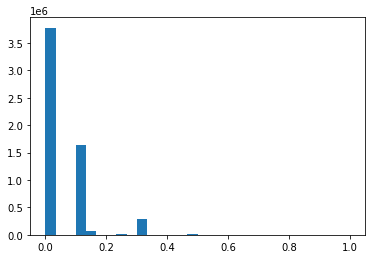

In [17]:
plt.hist(nor_interactions.rating,bins=30)

In [18]:
#from sklearn.preprocessing import StandardScaler
#std = StandardScaler()
#std.fit(interactions)
#std.transform(interactions)

### $ {\color{Red} {Make \,\, Dataset \,}}$

#### 1.Preprocessing data
> Important JOB : interaction 안되는 데이터 삭제 <br>
-> item_feature_source.movieId 가 ratings.movieId 에 100% join 되어야함 <br>
-> user_feature_source.userId 가 rating.userId에 100% mapping 되어야함 <br>

In [19]:
'''1) join 안되는 ID 삭제 > 2) sort_value['id'] > 3) reset_index()'''

ratings=user_item_interactions.loc[:,['userId','movieId','rating']].sort_values(by=['userId','movieId']).reset_index(drop=True)
df_item_features['genres']=df_item_features.genre_l.fillna('NaN')+'|'+df_item_features.genre_m.fillna('NaN')+'|'+df_item_features.genre_s.fillna('NaN') #장르결합 genre1/2/3
movies=df_item_features.loc[:,['movieId','title','genres','create_yr','director','actor1','wtch_cnt','sales_amt_3m']].fillna(0).sort_values(by=['movieId']).reset_index(drop=True)
users=df_user_features.loc[:,['userId','sex_cd','age5_band','pfgn1','avg_wtch_cnt','avg_fwtch_cnt','avg_buy_cnt','avg_buy_amt']].fillna(0).sort_values(by=['userId']).reset_index(drop=True)

def handle_movies(ratings,movies):

  #movies['genre']=list(map(lambda x:zlib.crc32(x.encode('UTF-8')), np.array(movies.genre.fillna(''))))
  tmp_movie=ratings.groupby('movieId')['rating'].mean()
  movies=pd.merge(tmp_movie,movies, on='movieId')
  idx_movie=movies.movieId[~movies.movieId.isin(ratings.movieId)].index
  movies.drop(idx_movie,inplace=True)
  movies.sort_values(by=['movieId'], inplace=True)
  movies.reset_index(drop=True, inplace=True)
  #print('movies',movies.columns)
  return movies

def handle_users(ratings,users):
  
  tmp_user=pd.DataFrame(ratings.userId.unique(),columns=['userId'])
  users=pd.merge(tmp_user,users, on='userId')
  idx_user=users.userId[~users.userId.isin(ratings.userId)].index
  users.drop(idx_user,inplace=True)
  users.sort_values(by=['userId'], inplace=True)
  users.reset_index(drop=True, inplace=True)
  #print('users',users.columns)
  return users

def handle_interactions(movies,users):

  idx_user=ratings.userId[~ratings.userId.isin(users.userId)].index
  ratings.drop(idx_user,inplace=True)
  idx_movie=ratings.movieId[~ratings.movieId.isin(movies.movieId)].index
  ratings.drop(idx_movie,inplace=True)
  ratings.sort_values(by=['userId','movieId'],inplace=True)
  ratings.reset_index(drop=True, inplace=True)
  #print('ratings',ratings.columns)
  return ratings

# 순방향 걸러내기
movies=handle_movies(ratings,movies)
users=handle_users(ratings,users)
ratings=handle_interactions(movies,users)
# 역방향 걸러내기
users=handle_users(ratings,users)
movies=handle_movies(ratings,movies.loc[:, movies.columns != 'rating'])

In [20]:
# rating, user, movies ID 갯수 동일 확인
print(users.shape[0],len(ratings.userId.unique()),movies.shape[0],len(ratings.movieId.unique()),ratings.shape[0])

293105 293105 25282 25282 5718243


In [21]:
# id 무결성 확인
#print(movies.movieId[~movies.movieId.isin(ratings.movieId)])
#print(users.userId[~users.userId.isin(ratings.userId)])
#print(ratings.userId[~ratings.userId.isin(ratings.userId)])
#print(ratings.movieId[~ratings.movieId.isin(movies.movieId)])

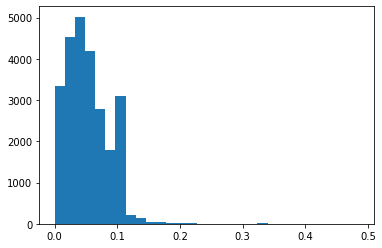

In [22]:
a=plt.hist(movies.rating,bins=30) #데이터분포확인

#### 2.Make Data Array

> ndex 가 비어 있으면 오류발생 : reset_index() 필요



In [23]:
from lightfm.data import Dataset
from scipy.io import mmwrite

In [24]:
#ratings.drop(columns=['rating_n'],inplace=True)
# 척도를 변환하고 반올림
ratings.rating=round((((ratings.rating - ratings.rating.min()) * ( 10 - 0 )) / ( ratings.rating.max() - ratings.rating.min())) + 0)
ratings

,userId,movieId,rating
0,-9223259533948962539,-5325328048293135553,0.0
1,-9223259533948962539,-816328911221559320,3.0
2,-9223259533948962539,2399654214069935366,0.0
3,-9223259533948962539,3462194398905494488,0.0
4,-9223237916653256333,-7666943246243350237,0.0
...,...,...,...
5718238,9223322056064380844,-3573952772207421421,1.0
5718239,9223322056064380844,-3037452211581368244,1.0
5718240,9223322056064380844,-2679473653912353406,1.0
5718241,9223322056064380844,-2546974551736097183,1.0


In [25]:
item_meta = movies[['movieId', 'title', 'genres', 'rating', 'create_yr']]

item_features_source = [(item_meta['movieId'][i],
                        np.array(item_meta.iloc[i,1:]).reshape(-1)) for i in range(item_meta.shape[0])]                                           

In [26]:
user_meta = users[['userId','sex_cd','age5_band','pfgn1','avg_wtch_cnt','avg_buy_amt']]

user_features_source = [(user_meta['userId'][i],
                        np.array(user_meta.iloc[i,1:]).reshape(-1)) for i in range(user_meta.shape[0])]                          

In [27]:
#결측치가 있는지 확인
'''
df=pd.DataFrame(ratings_source);print(pd.DataFrame(ratings_source).head(1))
df.isnull().sum()
df=pd.DataFrame(item_features_source);print(pd.DataFrame(item_features_source).head(1))
df.isnull().sum()
df=pd.DataFrame(user_features_source);print(pd.DataFrame(user_features_source).head(1))
df.isnull().sum()
'''

'\ndf=pd.DataFrame(ratings_source);print(pd.DataFrame(ratings_source).head(1))\ndf.isnull().sum()\ndf=pd.DataFrame(item_features_source);print(pd.DataFrame(item_features_source).head(1))\ndf.isnull().sum()\ndf=pd.DataFrame(user_features_source);print(pd.DataFrame(user_features_source).head(1))\ndf.isnull().sum()\n'

### $ {\color{yellow} {Fit \,dataset}}$
> dataset.fit -> dataset.build 순으로 각 데이터별로 번갈아 수행 해야함

In [28]:
ratings_source = [(ratings['userId'][i], ratings['movieId'][i], ratings['rating'][i]) for i in range(ratings.shape[0])]  # type : int형 only

In [29]:
dataset = Dataset()
dataset.fit(users=ratings['userId'],
            items=ratings['movieId'])

In [30]:
interactions, weights = dataset.build_interactions(ratings_source)

In [31]:
dataset.fit(users=ratings['userId'],
            items=ratings['movieId'],
            item_features=item_meta[item_meta.columns[1:]].values.flatten()
            )

In [32]:
item_features=dataset.build_item_features(item_features_source)

In [33]:
dataset.fit(users=ratings['userId'],
            items=ratings['movieId'],
            user_features=user_meta[user_meta.columns[1:]].values.flatten()
            )

In [34]:
user_features=dataset.build_user_features(user_features_source)

In [35]:
#print(pd.DataFrame(item_features_source))

In [36]:
# Save
mmwrite('interactions.mtx', interactions)
mmwrite('item_features.mtx', item_features)
mmwrite('weights.mtx', weights)
mmwrite('user_features.mtx',user_features)

In [37]:
#print(weights)

In [38]:
from lightfm.cross_validation import random_train_test_split
# Split Train, Test data
model = LightFM(loss='warp')

(train, test) = random_train_test_split(interactions=interactions, test_percentage=0.2)
start = time.time()
model.fit(train, item_features=item_features, user_features=user_features, epochs=10)
end = time.time(); print('time :',end-start) 

time : 151.50679087638855


#### $ {\color{yellow} {1.evaluation : precision@k, AUC }}$

In [39]:
start = time.time()
train_precision = precision_at_k(model, train, k=10,user_features=user_features,item_features=item_features).mean()
end = time.time(); print('time :',end-start) 
start = time.time()
test_precision = precision_at_k(model, test, k=10,user_features=user_features,item_features=item_features).mean()
end = time.time(); print('time :',end-start) 
start = time.time()
train_auc = auc_score(model, train,user_features=user_features,item_features=item_features).mean()
end = time.time(); print('time :',end-start) 
start = time.time()
test_auc = auc_score(model, test,user_features=user_features,item_features=item_features).mean()
end = time.time(); print('time :',end-start) 

print('Precision: train %.3f, test %.3f.' % (train_precision, test_precision))
print('AUC: train %.3f, test %.3f.' % (train_auc, test_auc))
'''
time : 633.9194025993347
time : 424.50309658050537
time : 634.1630313396454
time : 424.71241569519043
Precision: train 0.15, test 0.05.
AUC: train 0.97, test 0.96.
'''

time : 725.146790266037
time : 483.93767833709717
time : 727.2428233623505
time : 481.31432485580444
Precision: train 0.152, test 0.050.
AUC: train 0.970, test 0.967.


'\ntime : 633.9194025993347\ntime : 424.50309658050537\ntime : 634.1630313396454\ntime : 424.71241569519043\nPrecision: train 0.15, test 0.05.\nAUC: train 0.97, test 0.96.\n'

In [40]:
print('Precision: train %.3f, test %.3f.' % (train_precision, test_precision))
print('AUC: train %.3f, test %.3f.' % (train_auc, test_auc))

Precision: train 0.152, test 0.050.
AUC: train 0.970, test 0.967.


In [41]:
alpha = 1e-05
epochs = 3
num_components = 5
max_sampled=10

warp_model = LightFM(no_components=num_components,
                    loss='warp',
                    learning_schedule='adagrad',
                    max_sampled=max_sampled,
                    user_alpha=alpha,
                    item_alpha=alpha)

bpr_model = LightFM(no_components=num_components,
                    loss='bpr',
                    learning_schedule='adagrad',
                    user_alpha=alpha,
                    item_alpha=alpha)

warp_duration = []
bpr_duration = []
warp_auc = []
bpr_auc = []

for epoch in range(epochs):
    print(epoch);
    start = time.time()
    warp_model.fit_partial(train, epochs=1,user_features=user_features,item_features=item_features)
    warp_duration.append(time.time() - start);end = time.time(); print('time :',end-start) 
    warp_auc.append(auc_score(warp_model, test, train_interactions=train,user_features=user_features,item_features=item_features).mean()) #10분소요
    end = time.time(); print('time :',end-start) 


0
time : 9.982531785964966
time : 355.7433223724365
1
time : 10.125338792800903
time : 355.41736030578613
2
time : 10.115009784698486
time : 355.5893557071686


In [42]:
for epoch in range(epochs):
    print(epoch);
    start = time.time()
    bpr_model.fit_partial(train, epochs=1,user_features=user_features,item_features=item_features)
    bpr_duration.append(time.time() - start);end = time.time(); print('time :',end-start) 
    bpr_auc.append(auc_score(bpr_model, test, train_interactions=train,user_features=user_features,item_features=item_features).mean())
    end = time.time(); print('time :',end-start) 

0
time : 10.298367500305176
time : 408.83443427085876
1
time : 9.774319171905518
time : 391.6381494998932
2
time : 9.88328242301941
time : 388.1902365684509


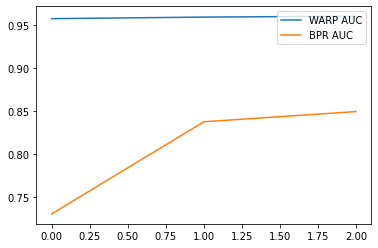

In [43]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_auc))
plt.plot(x, np.array(bpr_auc))
plt.legend(['WARP AUC', 'BPR AUC'], loc='upper right')
plt.show()

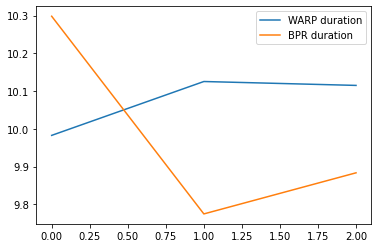

In [44]:
x = np.arange(epochs)
plt.plot(x, np.array(warp_duration))
plt.plot(x, np.array(bpr_duration))
plt.legend(['WARP duration', 'BPR duration'], loc='upper right')
plt.show()

#### $ {\color{yellow} {2.Recommend \,\,Movie\,\,List }}$

In [45]:
labels = np.array(movies['movieId'])

def sample_recommendation(model, data, user_ids):

    n_users, n_items = data.shape

    #build a structure to store user scores for each item
    all_scores = np.empty(shape=(0,n_items))

    #iterate through the group and build the scores
    for user_id in user_ids:
        #known_positives = labels[data.tocsr()[user_id].indices]
        #user의 전체 0~9066 movie의 예측 평점
        scores = model.predict(user_id,np.arange(n_items),item_features) 
        
        top_items_for_user = labels[np.argsort(-scores)] #argsort():오름차순인덱스반환
        print("Top Recommended movieId For User: ", user_id)
        for x in top_items_for_user[:3]:
            #print("     %s" % movies[movies['movieId']== x])
            print("     %s" % x)

        #vertically stack the user scores (items are columns)
        all_scores = np.vstack((all_scores, scores))
        #print(all_top_items)

    #compute the average rating for each item in the group
    item_averages = np.mean(all_scores.astype(np.float), axis=0)
    top_items_for_group = labels[np.argsort(-item_averages)]
    top_items_scores=item_averages[np.argsort(-item_averages)]

    print("Top Recommended movieId for Group:")

    for x in top_items_for_group[:5]:
        print("     %s" % x)
    return  top_items_for_group, top_items_scores

In [46]:
#group = [int(input('enter userid :'))]
#pd.DataFrame(sample_recommendation(model, interactions, group)).T

In [47]:
#################################
#                               #
#  Sampling Recommended Events  #
#                               #
#################################
np.set_printoptions(threshold=np.inf,linewidth=np.inf)
pd.set_option('display.max_columns', None)

#fetch user_ids of users in group
group = [int(input('enter userid :'))]

list,avg_scores = sample_recommendation(model, interactions, group)
recommend_movie=pd.DataFrame(columns=movies.columns)
'''
for x in list[:20]:
  recommend_movie=recommend_movie.append(movies[movies['movieId']== x], ignore_index=True)
'''
for x in list[:100]:
  recommend_movie=recommend_movie.append(movies[movies['movieId']== x], ignore_index=True)

recommend_movie['predict_score']= avg_scores[:100]
recommend_movie[recommend_movie.genres.str.split('|').str[1] !='성인'][:20].reset_index()# 성인제외
#recommend_movie[:20]


enter userid :11
Top Recommended movieId For User:  11
     -9167504850715679476
     -8134796277594556610
     -9088081590022333399
Top Recommended movieId for Group:
     -9167504850715679476
     -8134796277594556610
     -9088081590022333399
     -6957301239238394653
     -6654104387870140289


,index,movieId,rating,title,genres,create_yr,director,actor1,wtch_cnt,sales_amt_3m,predict_score
0,0,-9167504850715679476,0.033186,드럭스토어 카우보이,영화|드라마|NaN,2018,구스 반 산트,맷 딜런,13,1400.0,0.622651
1,1,-8134796277594556610,0.054767,부탁 하나만 들어줘,영화|스릴러|NaN,2019,폴 페이그,블레이크 라이블리,620,158200.0,0.598407
2,2,-9088081590022333399,0.028348,왕대륙의 기묘기사,영화|SF/판타지|NaN,2020,조소구,왕대륙,114,7500.0,0.593385
3,3,-6957301239238394653,0.010895,방세옥: 천하대전,영화|액션|NaN,2019,율심박,승색려,50,5000.0,0.576844
4,5,-6618847529950655177,0.016663,나인 풀 문스(9 Full Moons),영화|로맨스|NaN,2016,토머 알마고,에이미 세이메츠,141,53200.0,0.568527
5,6,-5565921388913898469,0.024061,헨리 5세,영화|액션|NaN,2018,케네스 브래너,케네스 브래너,27,7000.0,0.568327
6,8,-6654736372252959816,0.040772,거침없이 쏴라! 슛뎀업(Shoot `Em Up),영화|액션|NaN,2015,마이클 데이비스,클라이브 오웬,166,290000.0,0.565438
7,9,-2896663637457442894,0.034193,투 이즈 어 패밀리,영화|코미디|NaN,2017,위고 젤랭,오마 사이,39,9800.0,0.553778
8,10,-8134468053281070347,0.035200,비쎈,영화|액션|NaN,2020,로스 W. 클락슨,리에 리 천,115,27500.0,0.551832
9,13,-6438916458778381907,0.047052,지저귀는 새는 날지 않는다,영화|극장판 애니|로맨스,2020,마키타 카오리,신가키 타루스케,11,26000.0,0.545718


In [48]:
# 시청 정보
#i = int(input('enter userid : '))
i = int(input('enter userid :'))
pd.merge(ratings[ratings.userId==users.iloc[i][0]],movies, on='movieId')

enter userid :11


,userId,movieId,rating_x,rating_y,title,genres,create_yr,director,actor1,wtch_cnt,sales_amt_3m
0,-9222499131495171858,-8765309055107668895,0.0,0.045508,웨이 다운,영화|액션|NaN,2021,자움 발라구에로,프레디 하이모어,8186,28496000.0
1,-9222499131495171858,-2881349100186662098,0.0,0.019245,캐시트럭,영화|액션|NaN,2021,가이 리치,제이슨 스타뎀,4701,30600000.0
2,-9222499131495171858,-2260645583576098385,0.0,0.011261,소울,영화|극장판 애니|드라마,2021,피트 닥터,제이미 폭스,45970,0.0
3,-9222499131495171858,1592906744297345059,0.0,0.016063,마크맨,영화|액션|NaN,2021,로버트 로렌즈,리암 니슨,18123,100000000.0
4,-9222499131495171858,2615346061790891548,1.0,0.059024,엉덩이 탐정 극장판:려한 사건 수첩,영화|극장판 애니|어린이/가족,2021,히라야마 미호,김은아,36988,0.0
5,-9222499131495171858,8229125510814751668,0.0,0.009841,라야와 마지막 드래곤,영화|극장판 애니|액션,2021,"돈 홀, 카를로스 로페즈 에스트라다",켈리 마리 트란,61136,0.0


In [49]:
model.predict(265, [356], item_features)

array([0.0460449], dtype=float32)

In [50]:
pd.DataFrame(ratings[ratings.userId==users.iloc[12][0]])

,userId,movieId,rating
402,-9222475185513976242,-5633414720538420288,0.0
403,-9222475185513976242,-5058503078456968645,1.0
404,-9222475185513976242,-2418629155473076079,1.0
405,-9222475185513976242,2476773338372596358,0.0
406,-9222475185513976242,2767919627789712801,1.0


In [51]:
labels = np.array(ratings['movieId'])

In [52]:
n_users, n_items = interactions.shape
scores=model.predict(265,np.arange(n_items),item_features)

In [ ]:
"""
#ratings 에 없는 userId,movieId 삭제 -> 1)row dorp 후 2)sort_values['id'] 3) reset_index() 를 해줘야 error 안남
def drop_redundant_rows(n):
  '''1)drop redundant rows'''
  #user_item_interactions
  idx_user=user_item_interactions.userId[~user_item_interactions.userId.isin(df_user_features.userId)].index
  user_item_interactions.drop(idx_user,inplace=True)
  idx_movie=user_item_interactions.movieId[~user_item_interactions.movieId.isin(df_item_features.movieId)].index
  user_item_interactions.drop(idx_movie,inplace=True)

  #user_features
  idx_user=df_user_features.userId[~df_user_features.userId.isin(user_item_interactions.userId)].index
  df_user_features.drop(idx_user,inplace=True)
  #item_features
  idx_movie=df_item_features.movieId[~df_item_features.movieId.isin(user_item_interactions.movieId)].index
  df_item_features.drop(idx_movie,inplace=True)

  '''2) sort_values['id']'''
  df_item_features.sort_values(by=['movieId'],inplace=True)
  df_user_features.sort_values(by=['userId'],inplace=True)
  user_item_interactions.sort_values(by=['userId','movieId'],inplace=True)
  
  '''3) reset_index()'''
  ratings=user_item_interactions.loc[:,['userId','movieId','rating']].sort_values(by=['userId','movieId']).reset_index(drop=True)

  df_item_features['genres']=df_item_features.genre_l.fillna('NaN')+'|'+df_item_features.genre_m+'|'+df_item_features.genre_s
  movies=df_item_features.loc[:,['movieId','title','genres','create_yr','director','actor1','wtch_cnt','sales_amt_3m']].fillna(0).sort_values(by=['movieId']).reset_index(drop=True)
  #movies['genre']=list(map(lambda x:zlib.crc32(x.encode('UTF-8')), np.array(movies.genre.fillna(''))))
  tmp_movie=ratings.groupby('movieId')['rating'].mean()
  movies=pd.merge(tmp_movie,movies, on='movieId').sort_values(by=['movieId']).reset_index(drop=True)

  users=df_user_features.loc[:,['userId','sex_cd','age5_band','pfgn1','avg_wtch_cnt','avg_fwtch_cnt','avg_buy_cnt','avg_buy_amt']].fillna(0).sort_values(by=['userId']).reset_index(drop=True)

  print('order :',n,'\n')

drop_redundant_rows(1)
drop_redundant_rows(2)

print('user:',df_user_features.userId[~df_user_features.userId.isin(user_item_interactions.userId)],'\n','movie: ',df_item_features.movieId[~df_item_features.movieId.isin(user_item_interactions.movieId)])
print('user:',user_item_interactions.userId[~user_item_interactions.userId.isin(df_user_features.userId)],'\n','movie: ',df_item_features.movieId[~df_item_features.movieId.isin(user_item_interactions.movieId)])
"""